# Creating Custom Captum.optim Modules
Captum's Optim library contains an extensive list of optimization objectives, transforms, and input parameterizations. However, some cases may require adding new features to these areas of Captum's Optim library. Luckily adding them to Captum is easy!

In [ ]:
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, Iterable, List, Optional, Tuple, Union

import captum.optim as opt
import torch
import torchvision
from captum.optim.models import googlenet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

## Custom Image Transforms

If both Captum and Torchvision lack the transforms that you require, then you can create your own custom transforms.

Custom image transform classes must contain a `forward()` function. The first transform in a list of transforms takes an input tensor with a shape of (B, C, W, H), and the final transform in a list of transforms will need to output a tensor with the same shape of (B, C, W, H). Captum and Torchvision's transforms normally expect and output a shape of (B, C, W, H).

An optional `__init__()` function can be used as well.


Note that all custom transforms need to be autograd compatible, so that the gradient is not interrupted during the optimization process.


In [ ]:
class CustomTransform(torch.nn.Module):
    def __init__(self, val: int = 1) -> None:
        super().__init__()
        self.val = val

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input * self.val

## Custom Loss Objectives
Captum's loss objectives are composed of classes that the optimization function uses. Custom loss classes should inherit the base loss class `opt.loss.BaseLoss` and also have the `opt.loss.loss_wrapper` decorator.

For now, the `opt.loss.loss_wrapper` decorator primarily serves to update the name and string representations of the loss objective, but future work may also add other generic loss attributes via the decorator. This decorator is required for custom loss objectives.

Custom loss objectives must contain the following two functions:

**The init function**

* The `__init__()` function must at least contain a `target` variable. The `target` variable should be an `nn.module` or list of `nn.modules` to collect activations from. Other variables can be added after the `target`.

* An optional variable is `batch_index`, which is either an `int` or a list of `int`. The `batch_index` is used to target a specific image in a batch of input images.

* The init function should call the `BaseLoss` `__init__` function and provide it with the target `nn.Module` or list of `nn.Module` along with the `batch_index`.

**The call function**

* The `__call__()` function takes activations from the target layer and then returns a loss value. Activations sent to the call function are extracted from a dictionary with the target as the key.

In [ ]:
@opt.loss.loss_wrapper
class CustomLoss(opt.loss.BaseLoss):
    def __init__(
        self,
        target: Union[torch.nn.Module, List[torch.nn.Module]],
        batch_index: Optional[Union[int, List[int]]] = None, # Optional parameter
    ) -> None:
        opt.loss.BaseLoss.__init__(self, target, batch_index)

    def __call__(
        self, target_activations: Dict[torch.nn.Module, Optional[torch.Tensor]]
    ) -> torch.Tensor:

        # Get activations for target from input dict
        activations = target_activations[self.target]

        # self.batch_index is a tuple of (batch_index, batch_index+1)
        activations = activations[self.batch_index[0] : self.batch_index[1]]

        # Return activations for loss summarization
        return activations

## Custom Loss Summarize Functions

In addition to the loss objectives, there is also the loss summarization function that can be supplied to the `optimize` method of `InputOptimization`. This function dictates how the final loss is computed and aggregated before we call the `backward` method on it to compute gradients.

Here we show the default summarize function to give an idea of what this function does. The default summarize function simply computes the mean of the loss tensor and multiplies it by -1 so that the optimization maximizes the activations.

In [ ]:
def custom_loss_summarize(loss_value: torch.Tensor) -> torch.Tensor:
    return -1 * loss_value.mean()

## Custom Image Parameterization


The image parameters that Captum's Optim library optimizes to produce visualizations is stored in a custom image parameterization class. 

Custom parameterization must contain the following two functions:

### Init function

The `__init__()` function has 3 input variables:

* size (tuple, int): dimensions in the form height, width. 

* channels (int): the number of channels for the output tensor.

* batch (int): the desired batch size to use.

* init (torch.Tensor): An optional input tensor with a shape of: (B, C, W, H).

Make sure that the tensor being optimized is wrapped in `torch.nn.Parameter` and that it can be called by the `forward()` function.

Note that the `__init__()` function can contain any number of variable inputs if the image parameterization is passed as an instance to `NaturalImage`. Otherwise the init function requirements are required.

### Forward function

The `forward()` function has zero input variables and returns a 4 dimension tensor with a shape of (B, C, W, H):

* The tensor being optimized should be called from where it was saved in the init function. This tensor will then be returned when the forward function is called.

* The dimensions of the output tensor should be named: 'B', 'C', 'H', and 'W', unless you are using TorchScript / JIT.

* As JIT does not yet support named dimensions, you can use [`torch.jit.is_scripting`](https://pytorch.org/docs/stable/jit_language_reference.html?highlight=is_scripting#torch.jit.is_scripting) to only name the dimensions when not using JIT.

In [ ]:
class CustomImage(opt.images.ImageParameterization):
    def __init__(
        self,
        size: Tuple[int, int] = (224, 224),
        channels: int = 3,
        batch: int = 1,
        init: torch.Tensor = None,
    ) -> None:
        super().__init__()
        if init is None:
            assert size is not None
            # Create random input with a shape of: B, C, W, H
            init = torch.randn([batch, channels, size[0], size[1]])
        else:
            assert init.dim() == 4
        self.image = torch.nn.Parameter(init)  # Convert input to nn.Parameter()

    def forward(self) -> torch.Tensor:
        if torch.jit.is_scripting():
            return self.image
        return self.image.refine_names("B", "C", "H", "W")  # rename dimensions

## Custom StopCriteria

StopCriteria functions tell the `InputOptimization.optimize` function when to stop optimizing the input param. We provide 4 possible sources of information after each step for the stop criteria function to determine when to stop the optimization process.

The default Captum `opt.optimization.n_steps` function returns a stop criteria function called `continue_while`. The `continue_while` function takes 4 input variables every step during the optimization process:

* `step` (int): The current optimization step.

* `obj`: The current instance of InputOptimization being used.

* `history` (list of torch.Tensor): A list of loss values per iteration. The size of the list is equal to the number of steps that have already been performed. The last value in the list corresponds to the current step.

* `optim` (torch.optim.Optimizer): The current instance of the optimizer being used.

All stop criteria functions or classes using `__call__` functions, should accept the same 4 inputs as `continue_while`. They are also expected to return a boolean value for each step to indicate whether optimization should continue.

Note that these requirements may not exist for custom optimization functions, which can utilize their own custom stopping criteria.


In [ ]:
from tqdm.auto import tqdm


# Main setup function
def n_steps_custom(n: int, show_progress: bool = True):

    # Setup progress bar so that we can monitor progress
    if show_progress:
        pbar = tqdm(total=n, unit=" step")

    # The stop Criteria function
    def continue_while(
        step: int,
        obj: opt.InputOptimization,
        history: Iterable[torch.Tensor],
        optim: torch.optim.Optimizer,
    ) -> bool:
        if len(history) > 0:
            if show_progress:
                # Print current optimization step and loss value
                pbar.set_postfix(
                    {"Objective": f"{history[-1].mean():.1f}"}, refresh=False
                )

        # Return True if we haven't reached the target num of optimization steps
        if step < n:
            if show_progress:
                pbar.update()
            return True

        # Return False if we have reached the target num of optimization steps
        else:
            if show_progress:
                pbar.close()
            return False

    # Return StopCriteria function to use for optimization
    return continue_while


## Custom Optimization Functions

While the default `optimize` function from `InputOptimization` usually suffices for most use cases, you may find yourself needing something different. For example if you want to use a [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), or if you wish to use an optimizer like LBFGS which requires a `closure` function [passed to their step function](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step).

To create a custom optimization function, we will recreate the default `optimize` function while replacing `self` with the `InputOptimization` instance. We can then simply pass our `InputOptimization` instance to the function in order to render our results.

Important `InputOptimization` Functions & Attributes:

* The `.parameters()` function returns the list of input parameters requiring grad.
* The `.loss()` function returns the loss function values.
* The `.cleanup()` function removes the hooks that were used to collect activations.
* The image parameterization being used can be accessed via `.input_param` attribute.
* The model being used can be accessed via `.model` attribute.
* The transforms being used can be accessed via `.transforms` attribute.

In [ ]:
def custom_optimize(
    obj: opt.InputOptimization,
    stop_criteria: Optional[Callable] = None,
    optimizer: Optional[torch.optim.Optimizer] = None,
    loss_summarize_fn: Optional[Callable] = None,
    lr: float = 0.025,
) -> torch.Tensor:

    # Setup conditions for when to stop optimizing
    stop_criteria = stop_criteria or opt.optimization.n_steps(512)

    # Pass the parameters of our optimization task to the optimizer
    optimizer = optimizer or torch.optim.Adam(obj.parameters(), lr=lr)
    assert isinstance(optimizer, torch.optim.Optimizer)

    # Set the loss summarization function
    loss_summarize_fn = loss_summarize_fn or opt.loss.default_loss_summarize

    history: List[torch.Tensor] = []
    step: int = 0

    # Run optimization loop with protection
    try:

        # Stop criteria requires 4 variables from the optimization process
        while stop_criteria(step, obj, history, optimizer):
            optimizer.zero_grad()

            # Summarize any non scalar loss values
            loss_value = loss_summarize_fn(obj.loss())

            # Place loss values from the current step into history list
            history.append(loss_value.clone().detach())

            loss_value.backward()
            optimizer.step()
            # scheduler.step() #  LR Scheduler step location
            step += 1

    # Always run final clean up
    finally:
        obj.cleanup()

    # Return optimization loss history for all optimization steps
    return torch.stack(history)

## Running Captum with custom modules

Below is a helper function that will let us quickly and easily experiment with our custom modules from above. Random scaling and random spatial jitter transforms are also included in the helper function to improve output quality.

In [ ]:
def visualize(model: torch.nn.Module, target: torch.nn.Module):
    # Define our custom image parameterization, then add it to NaturalImage
    image_param = CustomImage
    image = opt.images.NaturalImage(
        size=(224, 224), parameterization=image_param, batch=2
    ).to(device)

    transforms = torch.nn.Sequential(
        CustomTransform(),  # Add our custom transform to the list of transforms
        # Additional transforms to improve output quality
        opt.transforms.RandomSpatialJitter(16),
        opt.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    )

    # Define our custom loss function as the loss function
    loss_fn = CustomLoss(
        target, batch_index=0  # Only optimize 0th image to demonstrate batch_index
    )

    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = custom_optimize(  # Our custom optimization function
        obj=obj,
        stop_criteria=n_steps_custom(512),  # Our custom stop criteria
        loss_summarize_fn=custom_loss_summarize,  # Our custom loss_summarize_fn
    )
    image().show(figsize=(10, 5), images_per_row=2)

And there you have it! Notice that only the left image (at index 0) is optimized since we specified `batch_index=0` when defining `loss_fn`. The right image is unchanged from its random initialization.

  0%|          | 0/512 [00:00<?, ? step/s]

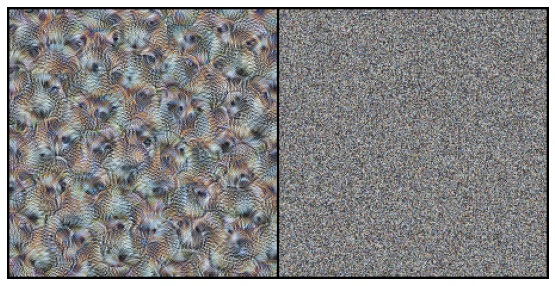

In [ ]:
visualize(model, model.mixed4a)

# Other Custom Modules

## Custom NaturalImage Modules

The requirements for creating your own variation of `NaturalImage` are extremely simple. The `forward` function should wrap the output in an `ImageTensor` instance. For JIT support, you can wrap the output in an `ImageTensor` instance inside a separate function that's wrapped with `@torch.jit.ignore`.

In [ ]:
class CustomNaturalImage(opt.images.ImageParameterization):
    def __init__(self, parameterization: opt.images.ImageParameterization) -> None:
        """
        Args:

            parameterization (ImageParameterization): The image parameterization
                instance you wish to use.
        """
        super().__init__()
        self.parameterization = parameterization

    @torch.jit.ignore
    def to_image_tensor(self, x: torch.Tensor) -> torch.Tensor:
        return opt.images.ImageTensor(x)

    def forward(self) -> torch.Tensor:
        """
        Collect the current parameterized tensor and wrap it in ImageTensor.

        Returns
            image(torch.Tensor): A PyTorch tensor.
        """
        image = self.parameterization()
        return self.to_image_tensor(image)  # Wrap output in opt.images.ImageTensor